<a href="https://colab.research.google.com/github/kmayutrisna/SA_IMDB/blob/main/4_IMDB_bert_CNN_Base_USE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.0 MB/s eta 0:00:00


In [2]:
#DATA PREPARATION
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, GlobalMaxPooling1D, Embedding, MaxPooling1D

In [3]:
#Get the dataset from gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Display top of data
data =pd.read_csv("drive/My Drive/data/IMDB Dataset.csv")
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
# Convert sentiment to binary labels
data['sentiment'] = data['sentiment'].map({'positive': 1, 'negative': 0})
data = data.sample(frac=1).reset_index(drop=True)  # Shuffling the dataset
X = data['review'].values
y = data['sentiment'].values

In [6]:
# Split the dataset into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [7]:
# Define the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [8]:
# Tokenize the texts and pad the sequences
train_encodings = tokenizer.batch_encode_plus(
    X_train.tolist(),
    truncation=True,
    padding=True,
    return_token_type_ids=False,
    max_length=512
)

In [9]:
val_encodings = tokenizer.batch_encode_plus(
    X_val.tolist(),
    truncation=True,
    padding=True,
    return_token_type_ids=False,
    max_length=512
)

In [10]:
test_encodings = tokenizer.batch_encode_plus(
    X_test.tolist(),
    truncation=True,
    padding=True,
    return_token_type_ids=False,
    max_length=512
)

In [11]:
# Convert the tokenized inputs to numpy arrays
train_inputs = np.array(train_encodings['input_ids'])
train_labels = np.array(y_train)

val_inputs = np.array(val_encodings['input_ids'])
val_labels = np.array(y_val)

test_inputs = np.array(test_encodings['input_ids'])
test_labels = np.array(y_test)


In [12]:
# Pad the sequences
train_inputs = pad_sequences(train_inputs, maxlen=512, padding='post')
val_inputs = pad_sequences(val_inputs, maxlen=512, padding='post')
test_inputs = pad_sequences(test_inputs, maxlen=512, padding='post')

In [13]:
model = Sequential()
model.add(Embedding(30522, 100, input_length=512))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [14]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
num_epochs = 5
batch_size = 16

# Lists to store accuracy values
train_acc_values = []
val_acc_values = []

In [16]:
# Train the model and track accuracy
for epoch in range(num_epochs):
    history = model.fit(train_inputs, y_train, epochs=1, batch_size=batch_size, validation_data=(val_inputs, y_val))

    # Extract accuracy values from history
    train_acc = history.history['accuracy'][0]
    val_acc = history.history['val_accuracy'][0]

    # Append accuracy values to the lists
    train_acc_values.append(train_acc)
    val_acc_values.append(val_acc)

2250/2250 [==============================] - 21s 9ms/step - loss: 0.0247 - accuracy: 0.9919 - val_loss: 0.4984 - val_accuracy: 0.8855


In [17]:
# Evaluate the model on the test dataset
predictions = model.predict(test_inputs)
y_pred = np.argmax(predictions, axis=1)

313/313 [==============================] - 1s 3ms/step


In [19]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
accuracy = accuracy_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)

In [20]:
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test Accuracy:", accuracy)
print("Test F1 Score:", f1)

Test Precision: 0.906301824212272
Test Recall: 0.8798551016301066
Test Accuracy: 0.8951
Test F1 Score: 0.8928826712958235


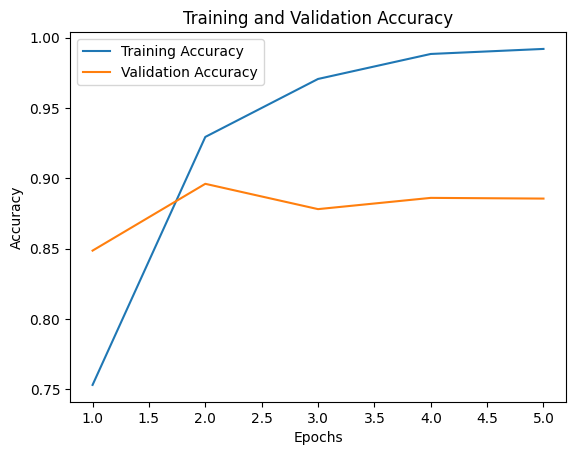

In [21]:
# Plot the performance chart
import matplotlib.pyplot as plt
plt.plot(range(1, num_epochs+1), train_acc_values, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_acc_values, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

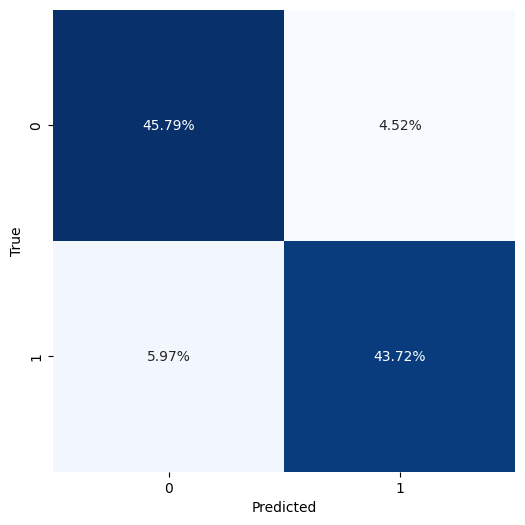

In [23]:
# Calculate the confusion matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
# Normalize the confusion matrix to display percentages out of the total
cm_norm = cm.astype('float') / cm.sum()

plt.figure(figsize=(6, 6))
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues', cbar=False, square=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()